In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from torch.utils.data.dataloader import default_collate

from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
info = pd.read_csv("dataset_info_5s.csv").query("50 < SBP < 220 and 30 < DBP < 180").sort_values(['subject', 'sample_num', 'split_num']).reset_index(drop=True)

In [26]:
start, end = 0, len(info)
tmp_info = info.iloc[start:end]
ppg_dataset = np.zeros((len(tmp_info), 625))
sbp_true = tmp_info['SBP'].values
dbp_true = tmp_info['DBP'].values

for i in tqdm(range(len(tmp_info))):
    path, subject = tmp_info.iloc[i][['sample_path', 'subject']]
    path = "_".join(path.split("_")[1:])
    sample = pd.read_csv(f"mimic_csv_5s/{subject}/{path}")
    ppg = sample['PPG'].values
    if len(ppg) == 626:
        ppg = ppg[:-1]
    ppg_dataset[i] = ppg

  0%|          | 0/682805 [00:00<?, ?it/s]

In [59]:
class BPDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, ppg_dataset, sbp, dbp, sample_len=5):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.seq_len = 125
        self.ppg_dataset = ppg_dataset
        self.sbp = sbp
        self.dbp = dbp
        self.y = torch.tensor(sbp).float()
        self.X = torch.tensor(ppg_dataset).float()


    def __len__(self):
        return len(self.ppg_dataset)#int(len(self.ppg_dataset) // self.seq_len)

    def __getitem__(self, i):
        # if i >= self.seq_len - 1:
        #     i_start = i - self.seq_len + 1
        #     x = self.X[i_start:(i + 1), :]
        # else:
        #     padding = self.X[0].repeat(self.seq_len - i - 1, 1)
        #     x = self.X[0:(i + 1), :]
        #     x = torch.cat((padding, x), 0)
        # return self.X[i], self.y[i]
        return self.X[i][::5].reshape(-1, 1), self.y[i]

        # if torch.is_tensor(idx):
        #     idx = idx.tolist()
        # start_idx = idx * self.seq_len
        # end_idx = start_idx + self.seq_len
        # print(start_idx, end_idx)
        # x = self.ppg_dataset[start_idx:end_idx]
        # sample = x, self.sbp[idx], self.dbp[idx]#self.ppg_dataset[start_idx:end_idx], self.sbp[idx], self.dbp[idx]
        # return sample

In [60]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_features, hidden_units, num_layers):
        super().__init__()
        self.num_features = num_features  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )
        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units, device=device).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units, device=device).requires_grad_()

        _, (h, _) = self.lstm(x, (h0, c0))
        out = self.linear(h[-1]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.
        return out

In [89]:
def validate(model, loss_fn, data_loader):
    total_loss = 0
    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_fn(output, y).item()
    avg_loss = total_loss / len(data_loader)
    return avg_loss

def train(model, loss_fn, optimizer, train_dl, val_dl, n_epochs=200):
    for epoch in range(n_epochs):
        model.train()
        for X, y in train_dl:
            output = model(X)
            loss = loss_fn(output, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = validate(model, loss_fn, train_dl)
        val_loss = validate(model, loss_fn, val_dl)
        print(f"Epoch {epoch}: train_loss: {train_loss:.3f},   val_loss: {val_loss:.3f}")

In [82]:
train_end = int(0.8 * len(info))
val_end = int(0.9 * len(info))
batch_size = 256

features_scaler = StandardScaler()
ppg_dataset_transformed = features_scaler.fit_transform(ppg_dataset)

target_1_scaler = StandardScaler()
sbp_transformed = target_1_scaler.fit_transform(sbp_true.reshape(-1, 1)).flatten()

target_2_scaler = StandardScaler()
dbp_transformed = target_2_scaler.fit_transform(dbp_true.reshape(-1, 1)).flatten()

features = ppg_dataset_transformed
target_1 = sbp_transformed
target_2 = dbp_transformed

train_ds = BPDataset(features[:train_end], target_1[:train_end], target_2[:train_end])
val_ds = BPDataset(features[train_end:val_end], target_1[train_end:val_end], target_2[train_end:val_end])
test_ds = BPDataset(features[val_end:], target_1[val_end:], target_2[val_end:])

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

In [99]:
class CNNLSTM(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(125, 256, 1),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Conv1d(256, 128, 1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Conv1d(128, 128, 1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
        )
        self.bilstm = nn.LSTM(128, 128, bidirectional=True, batch_first=True)
        self.lstm = nn.LSTM(256, 128, batch_first=True)
        self.linear = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.cnn(x)
        x = x.reshape(x.shape[0], 1, 128)
        x, hidden = self.bilstm(x)
        x = nn.Tanh()(x)
        x, hidden = self.lstm(x)
        x = nn.Tanh()(x)
        x = self.linear(x)
        return x.reshape(x.shape[0])

In [100]:
learning_rate = 1e-3
num_hidden_units = 32
num_features = 1
num_layers = 2

model_1 = ShallowRegressionLSTM(num_features=num_features, hidden_units=num_hidden_units, num_layers=num_layers).to(device)
model_2 = CNNLSTM().to(device)

model = model_2

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [101]:
train(model, loss_fn, optimizer, train_dl, val_dl, n_epochs=500)

Epoch 0: train_loss: 0.968,   val_loss: 0.966
Epoch 1: train_loss: 0.954,   val_loss: 0.947
Epoch 2: train_loss: 0.940,   val_loss: 0.983
Epoch 3: train_loss: 0.935,   val_loss: 0.961
Epoch 4: train_loss: 0.924,   val_loss: 0.969
Epoch 5: train_loss: 0.928,   val_loss: 0.980
Epoch 6: train_loss: 0.920,   val_loss: 0.968
Epoch 7: train_loss: 0.910,   val_loss: 0.951


KeyboardInterrupt: 

In [102]:
from sklearn.metrics import mean_absolute_error

def predict(model, data_loader):
    output = torch.tensor([], device=device)
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_pred = model(X).to(device)
            output = torch.cat((output, y_pred), 0)
    return output

train_preds = predict(model, train_dl).cpu().numpy()
val_preds = predict(model, val_dl).cpu().numpy()

train_preds_inv_transformed = target_1_scaler.inverse_transform(train_preds.reshape(-1, 1))
val_preds_inv_transformed = target_1_scaler.inverse_transform(val_preds.reshape(-1, 1))

In [103]:
val_true = sbp_true[train_end:val_end]

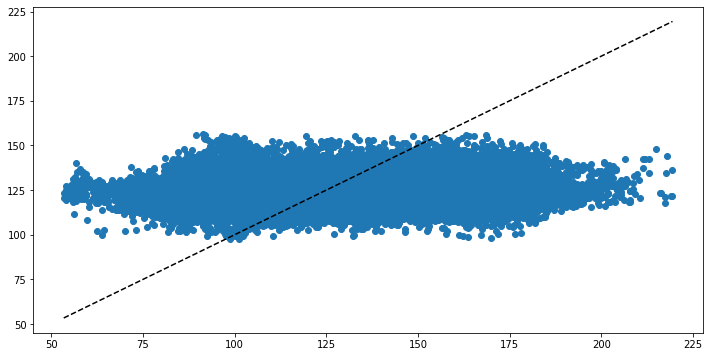

In [105]:
plt.figure(figsize=(12, 6))
plt.scatter(val_true, val_preds_inv_transformed)
plt.plot([val_true.min(), val_true.max()], [val_true.min(), val_true.max()], ls='--', c='k')

In [72]:
from sklearn.preprocessing import StandardScaler

In [106]:
mean_absolute_error(val_true, val_preds_inv_transformed.flatten())

19.335196602730324

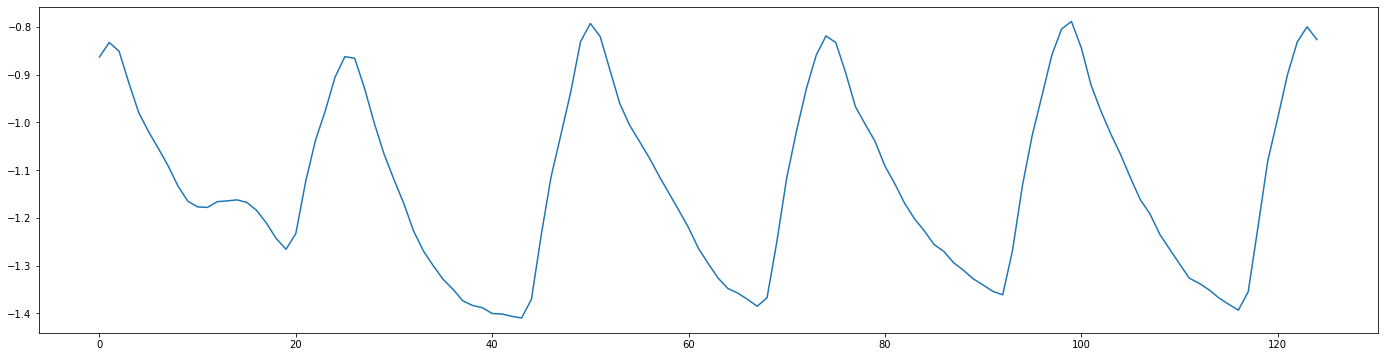

In [114]:
plt.figure(figsize=(24, 6))
plt.plot(ppg_dataset_transformed[1][::5])